In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_diabetes
import numpy as np

## 1.对数据集进行切分

In [40]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80000, random_state=10)

X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    X_full_train, y_full_train, test_size=0.5, random_state=10
)

In [41]:
n_estimators = 10
max_depth = 3

## 2. 单纯用随机森林或gbdt做分类

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

lr_clf=LogisticRegression()
lr_clf.fit(X_full_train, y_full_train)


random_forest = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

GradientBoostingClassifier(n_estimators=10, random_state=10)

In [43]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

## 3. 随机森林或gbdt+lr做分类

In [49]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder


def rf_apply(X, model):
    return model.apply(X)


rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={"model": random_forest})

rf_model = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
rf_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rf_apply at 0x0000018B10C5B948>,
                                     kw_args={'model': RandomForestClassifier(max_depth=3,
                                                                              n_estimators=10,
                                                                              random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]


gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={"model": gradient_boosting}
)

gbdt_model = make_pipeline(
    gbdt_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
gbdt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function gbdt_apply at 0x0000018B0CA39828>,
                                     kw_args={'model': GradientBoostingClassifier(n_estimators=10,
                                                                                  random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## 4.最终效果评估

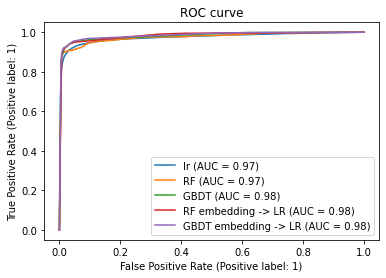

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

models = [
    ("lr",lr_clf),
    ("RF", random_forest),
    ("GBDT", gradient_boosting),
    ("RF embedding -> LR", rf_model),
    ("GBDT embedding -> LR", gbdt_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("ROC curve")

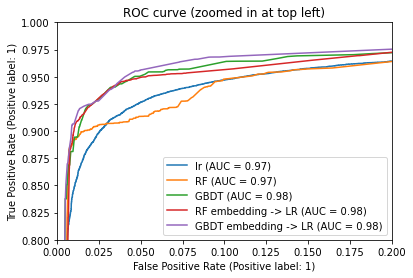

In [51]:
fig, ax = plt.subplots()
for name, pipeline in models:
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title("ROC curve (zoomed in at top left)")

In [52]:
RocCurveDisplay.from_estimator?